In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np



In [ ]:
dataset=pd.read_csv('../content/housing.csv')
dataset=dataset.dropna()
print("Here is the first ten row of the data set")
dataset.head(10)


here are the first ten row of the data set


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY
6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY
7,-122.25,37.84,52.0,3104.0,687.0,1157.0,647.0,3.1200,241400.0,NEAR BAY
8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY
9,-122.25,37.84,52.0,3549.0,707.0,1551.0,714.0,3.6912,261100.0,NEAR BAY


In [ ]:
x = dataset.iloc[0:20]

In [ ]:
df = pd.DataFrame(x, columns = ['longitude', 'latitude', 
                                'housing_median_age', 
                                'total_rooms', 'total_bedrooms',
                                'population',
                                'households','median_income'])

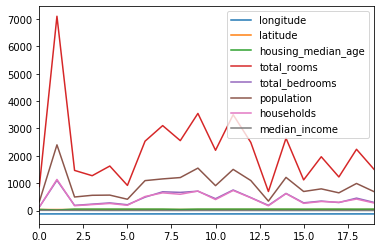

In [ ]:
df.plot()

In [ ]:

Y=dataset['median_house_value']
X=dataset.loc[:,'longitude':'median_income']

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(X, Y ,test_size=0.2)
x_train_np= x_train.to_numpy()
y_train_np= y_train.to_numpy()

x_test_np= x_test.to_numpy()
y_test_np= y_test.to_numpy()


In [ ]:
import torch
from torch.nn import Conv1d
from torch.nn import MaxPool1d
from torch.nn import Flatten
from torch.nn import Linear
from torch.nn.functional import relu
from torch.utils.data import DataLoader,TensorDataset


In [ ]:
class CnnRegressor(torch.nn.Module):
    def __init__(self,batch_size, inputs, outputs):
        super(CnnRegressor,self).__init__()
        self.batch_size=batch_size
        self.inputs=inputs
        self.outputs=outputs
        
        self.input_layer=Conv1d(inputs,batch_size,1)
        self.max_pooling_layer= MaxPool1d(1)
        self.conv_layer=Conv1d(batch_size,128,1)
        self.flatten_layer=Flatten()
        self.linear_layer=Linear(128,64)
        self.output_layer=Linear(64,outputs)
    def feed(self,input):
        input=input.reshape(self.batch_size,self.inputs,1)
        output=relu(self.input_layer(input))
        output=self.max_pooling_layer(output)
        output=relu(self.conv_layer(output))
        output=self.flatten_layer(output)
        output=self.linear_layer(output)
        output=self.output_layer(output)
        return output

In [ ]:
from torch.optim import SGD
!pip install pytorch-ignite
from torch.nn import L1Loss
from ignite.contrib.metrics.regression.r2_score import R2Score

     |████████████████████████████████| 112kB 29.7MB/s 


In [ ]:
batch_size=64
model=CnnRegressor(batch_size, X.shape[1], 1)
model.cuda()

CnnRegressor(
  (input_layer): Conv1d(8, 64, kernel_size=(1,), stride=(1,))
  (max_pooling_layer): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv_layer): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
  (flatten_layer): Flatten()
  (linear_layer): Linear(in_features=128, out_features=64, bias=True)
  (output_layer): Linear(in_features=64, out_features=1, bias=True)
)

In [ ]:
def model_loss(model,dataset,
               train=False,
               optimizer=None):
    performance=L1Loss()
    score_metric=R2Score()
    
    avg_loss=0
    avg_score=0
    count=0
    for input,output in iter(dataset):
        predictions=model.feed(input)
        loss=performance(predictions,output)
        score_metric.update([predictions,output])
        score=score_metric.compute()
        if(train):
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        avg_loss += loss.item()
        avg_score += score
        count += 1
    return avg_loss/count,avg_score/count


In [ ]:
epochs = 100
optimizer = SGD(model.parameters(),lr=1e-5)
inputs=torch.from_numpy(x_train_np).cuda().float()
outputs=torch.from_numpy(y_train_np.reshape(y_train_np.shape[0],1)).cuda().float()
tensor= TensorDataset(inputs,outputs)
loader= DataLoader(tensor,batch_size,shuffle=True, drop_last=True)

In [ ]:
for epoch in range(epochs):
  avg_loss,avg_r2_score=model_loss(model,loader,
                                   train=True,
                                   optimizer=optimizer)
  print("Epoch"+str(epoch+1)+":\n\tLoss="
  +str(avg_loss)+"\n\tR^2Score="
  +str(avg_r2_score))
  

Epoch1:
	Loss=131263.99451593138
	R^2Score=-1.971421152615133
Epoch2:
	Loss=115399.43468137254
	R^2Score=-1.0736918694897604
Epoch3:
	Loss=112113.09764093137
	R^2Score=-0.9735294162614586
Epoch4:
	Loss=108874.83327205882
	R^2Score=-0.8334127849801213
Epoch5:
	Loss=107447.96669730393
	R^2Score=-0.7147338937118046
Epoch6:
	Loss=104114.14712009804
	R^2Score=-0.5208066578039258
Epoch7:
	Loss=102433.23031556372
	R^2Score=-0.4745590255450239
Epoch8:
	Loss=99809.40637254903
	R^2Score=-0.3813422315828071
Epoch9:
	Loss=97485.87858455883
	R^2Score=-0.3597246476695532
Epoch10:
	Loss=96243.0172947304
	R^2Score=-0.35156936480377643
Epoch11:
	Loss=93457.65226715687
	R^2Score=-0.31951641132246683
Epoch12:
	Loss=92349.0859375
	R^2Score=-0.12222552578727133
Epoch13:
	Loss=92167.69453125
	R^2Score=-0.09524533573559353
Epoch14:
	Loss=91142.74742647058
	R^2Score=-0.12870195853600916
Epoch15:
	Loss=89996.68131127451
	R^2Score=-0.08654718485388145
Epoch16:
	Loss=91317.81525735294
	R^2Score=-0.11152977801811

In [ ]:
inputs = torch.from_numpy(x_test_np).cuda().float()
outputs = torch.from_numpy(y_test_np.reshape(y_test_np.shape[0], 1)).cuda().float()
tensor = TensorDataset(inputs,outputs)
loader = DataLoader(tensor, batch_size, shuffle=True,drop_last=True)
avg_loss, avg_r2_score = model_loss(model, loader)
print("The model L1 loss is:" + str(avg_loss))
print("The model R^2 loss is:" + str(avg_r2_score))


The model L1 loss is:76328.23127480158
The model R^2 loss is:0.21725880396773078
